# Multimode Beam Shaping with Cascaded Phase Masks

## Physical Context

Multimode light sources such as multimode fibers or filtered laser diodes exhibit complex spatial intensity patterns due to the incoherent superposition of many modes. Shaping these sources is challenging because each mode must be individually transformed to contribute constructively to the desired target intensity. This problem is relevant for laser materials processing, optical manipulation, and beam homogenization applications.

The approach demonstrated here builds on algorithmic methods for holographic beam shaping of partially coherent light [1,2], using gradient-based optimization to find optimal phase patterns that transform each mode appropriately. While the original work addressed systems with thousands of modes (LP modes from step-index fibers), we use 105 Laguerre-Gaussian modes here for computational efficiency. LG modes form a complete basis for graded-index fibers and provide a good approximation for demonstrating the multimode shaping principle.

In this example, we optimize a cascade of two phase masks separated by free-space propagation to transform the multimode input into a flat-top intensity distribution. The automatic differentiation capability of JAX enables efficient gradient computation through the entire optical propagation chain, making it possible to optimize hundreds of thousands of phase parameters simultaneously.

[1] N. Barré and A. Jesacher, "Holographic beam shaping of partially coherent light," *Opt. Lett.* **47**, 425-428 (2022).

[2] N. Barré and A. Jesacher, "Beam shaping of highly multimode sources with cascaded diffractive optical elements," *Procedia CIRP* **111**, 566-570 (2022).

## Setup and Imports

In [1]:
import equinox as eqx
import optax
import jax
import jax.numpy as jnp
from jaxoptics import *
import matplotlib.pyplot as plt
import tqdm

## Define Multimode Input Beam and Target Profile

This function generates a super-Gaussian profile that approximates a flat-top beam. The parameter `n` controls the edge sharpness—higher values create sharper transitions from the flat region to zero:

In [2]:
def square(c0: float, n: float):
    def mode(x, y):
        return jnp.exp(-((x/c0)**n + (y/c0)**n))
    return mode

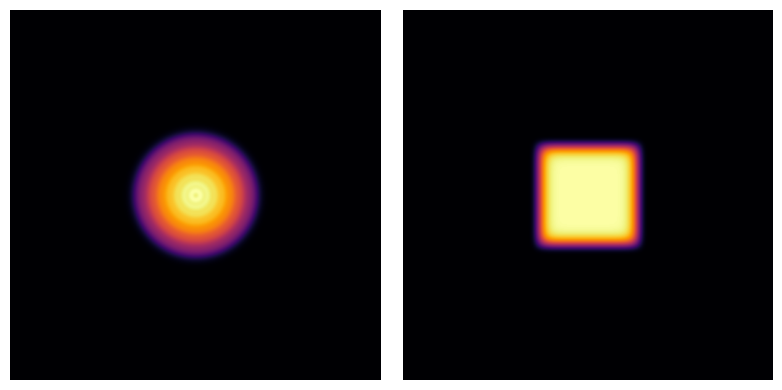

(<Figure size 800x400 with 2 Axes>, array([<Axes: >, <Axes: >], dtype=object))

In [3]:
# Simulation parameters
ns = (512, 512)      # Grid size
ds = (1.0, 1.0)      # Pixel size (μm)
wavelength = 0.532   # Green light (μm)
w_in = 25.0          # Gaussian waist (μm)
n_groups = 14        # Number of LG mode groups
cf = 75.0            # Flat-top width (μm)
n = 10               # Super-Gaussian order (sharp edges)

# Generate input modes: 105 Laguerre-Gaussian modes
input_modes = generate_mode_stack(laguerre_gaussian_groups(n_groups, w_in), ns, ds)
u0 = ScalarField(input_modes, ds, wavelength)
u0 = normalize_power(u0)
n_modes = len(u0)

# Target flat-top beam
xv, yv = spatial_grid(ns, ds)
target_intensity = jnp.abs(square(cf, n)(xv, yv))**2

# Normalize target to match total input power
I_square = target_intensity / jnp.sum(target_intensity) * jnp.prod(jnp.array(ds)) * n_modes

# Visualize input modes and target intensity
visualize_intensity(u0, jnp.sqrt(I_square))

In [4]:
# Verify Power Conservation
(sum(u0.power), jnp.sum(I_square))  # Should give (~105, ~105) - power is conserved

(Array(105., dtype=float32), Array(104.99999, dtype=float32))

## Build Optical System

We construct a system with two phase masks separated by propagation:

In [5]:
z0 = 500.0     # Propagation distance before/after phase masks (μm)
z12 = 1500.0   # Propagation distance between the two masks (μm)

# Propagators (non-trainable distances)
p0 = ASProp(u0, z0, trainable=False)
p12 = ASProp(u0, z12, trainable=False)

# Phase masks (trainable)
phi1 = Phase(u0, trainable=True)
phi2 = Phase(u0, trainable=True)

# Full system: propagate → phase1 → propagate → phase2 → propagate
system = OpticalSequence(p0, phi1, p12, phi2, p0)

## Define Loss and Optimization

We minimize squared error between output intensity and target:

In [6]:
def loss_fn(s, u, I_target):
    return jnp.sum(jnp.abs(jnp.sum(jnp.abs(s(u).electric)**2, axis=0) * jnp.prod(jnp.array(ds)) - I_target)**2)

@eqx.filter_jit
@eqx.filter_value_and_grad
def grad_fn(s, u, I_target):
    return loss_fn(s, u, I_target)

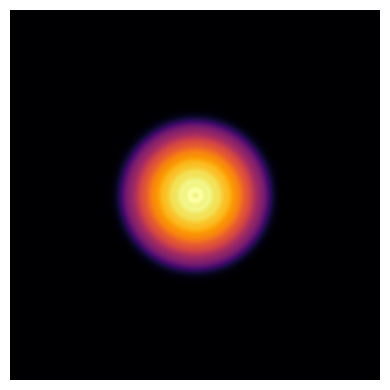

(<Figure size 400x400 with 1 Axes>, [<Axes: >])

In [7]:
# Initial output (before optimization)
uf = system(u0)
visualize_intensity(uf)

## Setup Optimizer with Selective Training

We use `optax.partition` to train only phase masks while freezing propagators:

In [8]:
no_optim = optax.set_to_zero()

def label_fn(s):
    if isinstance(s, OpticalSequence):  
        # Recursively apply label_fn on each layer while preserving structure
        return OpticalSequence(*map(label_fn, s.optical_components))
    elif isinstance(s, Phase):
        if s.is_trainable:
            return eqx.tree_at(lambda layer: layer.phase_mask, s, "phase_mask")
        else:
            return eqx.tree_at(lambda layer: layer.phase_mask, s, "frozen")
    elif isinstance(s, ASProp) or isinstance(s, RSProp):
        if s.is_trainable:
            return eqx.tree_at(lambda layer: (layer.kernel, layer.z), s, ("frozen", "prop_z"))
        else:
            return eqx.tree_at(lambda layer: (layer.kernel, layer.z), s, ("frozen", "frozen"))
    else:
        return jax.tree_at(lambda _: "frozen", s)

In [9]:
# Initialize optimizer
# optim = optax.nadam(0.1)
optim = optax.sgd(1000, momentum=0.98, nesterov=True)
tx = optax.transforms.partition({"phase_mask":optim, "frozen":no_optim}, label_fn)
opt_state = tx.init(system)

## Training Loop

In [10]:
@jax.jit
def train_step(s, opt_state, u, I_target):
    loss, grads = grad_fn(s, u, I_target)
    updates, opt_state = tx.update(grads, opt_state)
    system = eqx.apply_updates(s, updates)
    return system, opt_state, loss

In [11]:
# Run optimization
system = OpticalSequence(p0, phi1, p12, phi2, p0)  # Resets the system
losses = []

In [12]:
n_iter = 1500
for i in tqdm.trange(n_iter, desc="Optimizing"):
    system, opt_state, loss = train_step(system, opt_state, u0, I_square)
    losses.append(float(loss))

Optimizing: 100%|██████████████████████████████████████████████████████| 1500/1500 [00:53<00:00, 28.20it/s]


## Results

### Loss Curve

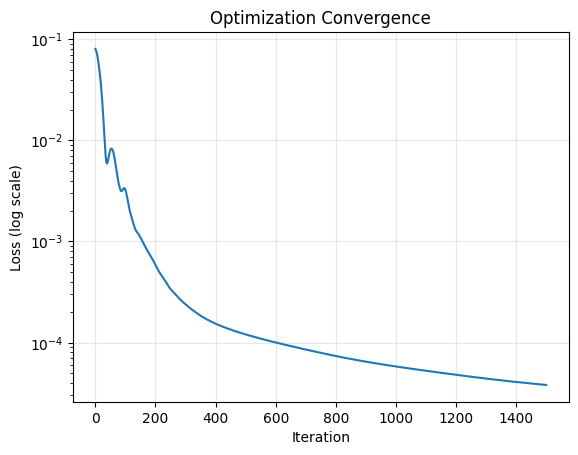

In [13]:
plt.figure()
plt.semilogy(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss (log scale)')
plt.title('Optimization Convergence')
plt.grid(True, alpha=0.3)
plt.show()

### Total Output Intensity vs Target

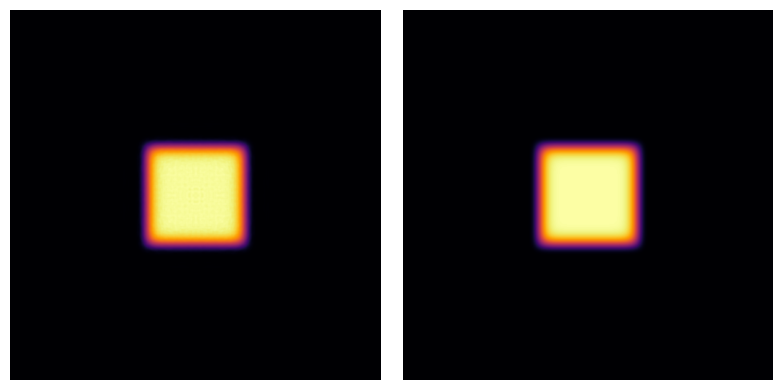

(<Figure size 800x400 with 2 Axes>, array([<Axes: >, <Axes: >], dtype=object))

In [14]:
uf = system(u0)
visualize_intensity(uf, jnp.sqrt(I_square))

### Optimized Phase Masks

In [15]:
def extract_phase_masks(system):
    masks = [comp.phase() for comp in system.optical_components if isinstance(comp, Phase)]
    return jnp.stack(masks, axis=0) if masks else None

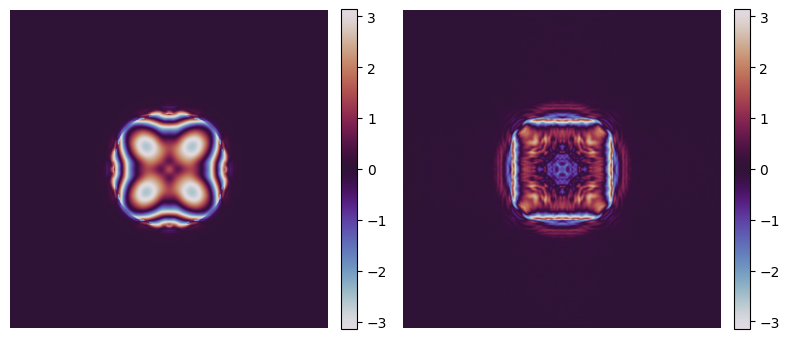

(<Figure size 800x400 with 4 Axes>, array([<Axes: >, <Axes: >], dtype=object))

In [16]:
# Visualize phases (wrapped to [-π, π])
visualize_fields(*jnp.angle(jnp.exp(1j*extract_phase_masks(system))), transform=jnp.real, cmap='twilight', colorbar=True)